# QuaSaR: Identifying EEW Rings - Shield Network and Fault Lines

[Quake Safe Rings](./1a_stations_faultlnes_plot.ipynb) - in our efforts to understand the station fault topology - we make use of the International Federation Data of Seismic Networks (FDSN), the global standard and a [data service](http://www.fdsn.org/services/) for sharing seismic sensor wave form data. The Obspy librarires support FDSN. The list of resources and services that are used for retrieving station inventory and waveform data.

In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('default')     #switch betweeb 'default' and 'ignore'

# Overview of Seismographs
[A seismograph is characterize](https://www.src.com.au/choosing-an-earthquake-sensor/) by its combination of low noise, high resolution, wide input signal range, and quickness of sampling data points. Sensors were then designed to tell us about change in velocity over time – acceleration. Earthquake monitoring stations have two sensors to record: strong motion and weak motion. [These sensors tend to overlap in range](https://www.analog.com/en/analog-dialogue/articles/understanding-the-fundamentals-of-earthquake-signal-sensing-networks.html#), which allows us to record pretty much the full range of ground displacement. Geophone low cost velocity sensors are high frequency seismographs that can typically record signals that shake at around 5Hz (5 cycles per second) or faster. The focus is on motion sensors of type: _(i) accelerometer, (ii) broadband velocity, (iii) short period velocity, and (iv) GNSS_.

1. __Broadband seismometers__
   1. extremely sensitive devices record seismic energy across a large range of frequencies (100-200Hz) 
   1. usually record seismic velocity on three channels: up-down, east-west, and north-south
   1. capture very small ground motions that are induced by small local or regional earthquakes, or very distant earthquakes
   1. do not perform well in the large ground motions induced by strong or nearby earthquakes
   1. strong shaking will cause broadband seismometers to “clip”, or go off scale
   1. used for scientific purposes
1. __Strong-motion seismometers__
   1. do not excel at detecting the very faint seismic signals that are captured by broadbands
   1. have a large dynamic range, and can record even very large ground motions
   1. well-suited to engineering applications
   1. dense networks of these sensors will often be located in urban environments or around critical infrastructure
   1. able to record accelerations up to 2 times the earth’s acceleration due to gravity, or 2g (accelerometers can measure up to 3.5 g with a system noise level less than 1μg/√Hz)
   1. shakemap input into a model are able to estimate shaking intensity over a large region
1. __Weak-motion seismometers__
   1. Weak motion sensors can measure very low amplitude seismic signals with a noise level of less than 1ng/√Hz
1. __GNSS seismometers__
   1. do not clip in the presence of large ground motions
   1. they are useful for recording large, nearby earthquakes (like a strong-motion seismometer)
   1. record the full spectrum of earthquake ground motion
   1. unique in recording the non-elastic ground motion that occurs during a large earthquake


# Sensor code and type definitions
<a id='sensor_code_desc'></a>

An initiatl step for object 1.A is determining the the types of operational seismic sensors and their locations. GoeNet hosts wave forms for a multitude of [sensor types](https://api.geonet.org.nz/network/sensor/type) (e.g. tidle guages, pressure gauges, seismometers, GNSS antennas, barometers, Microphones, Hydrophones and so on).

The sensors location code is unique to each sensor type. Therefore, one may chose to use the location code prefix or sensor type enumerator to select the desired sensors; i.e. seimograph and accelerometer stations. The motion sensors are used in both earthquake and volcanic seismic activity monitoring and early warning.

Channel codes are defined in the GeoNet's [stream naming conventions](https://www.geonet.org.nz/data/supplementary/channels)

| Sensor types that are relevant to earthquake detection | Location codes reserved for the seismic sensors | Channel codes first letter sensor type sampling rate and sensor bandwidth | Channel codes second letter sensor type relevant to seismometers |
|------------------------- |------------------------- |------------------------- |------------------------- |
|1 - Accelerometer |1? - weak motion sensors |U - Ultra Long Period sampled at 0.01Hz, or SOH sampled at 0.01Hz |H - Weak motion sensor, e.g. measuring velocity |
|3 - Broadband Seismometer |2? - strong motion sensors |V - Very Long Period sampled at 0.1Hz, or SOH sampled at 0.1Hz |N - Strong motion sensor, e.g. measuring acceleration |
|4 - GNSS Antenna | |L - Broad band sampled at 1Hz, or SOH sampled at 1Hz |L - Low gain sensor, usually velocity |
|8 - Short Period Borehole Seismometer | |B - Broad band sampled at between 10 and 80 Hz, usually 10 or 50 Hz |M - Mass position, used for monitoring broadband sensors |
|9 - Short Period Seismometer | |S - Short-period sampled at between 10 and 80 Hz, usually 50 Hz | |
|10 - Strong Motion Sensor | |H - High Broad band sampled at or above 80Hz, generally 100 or 200 Hz | |
| | |E - Extremely Short-period sampled at or above 80Hz, generally 100 Hz | |

_Example_: NZ.ADCS.20.HN1

NZ   = New Zealand country code  
ADCS = Unique station code  
20   = 2* 'strong motion' sensor location  
HN1  = \*\*1 North-South direction channel  

# OBJECTIVE 1.A - ANALYZE THE STATION TOPOLOGY

The objective is to analyze the station topology for its potential in serving as a low-latency shield network rings. It is part of [objective 1 described in the introdution](0_Introductions.ipynb)

## Get list of valid stations
We make use of the ../lib/stations.py class methods to retrieve the station inventory data and present a summary of the retrieved data.

In [5]:
''' Get all stations  '''
import sys
sys.path.insert(1, '../lib')
import stations

try:
    cls_st = stations.station_data()
    __client = cls_st.get_client()
    st_list, invalid_st_list, _ = cls_st.get_stations(__client)
    if not st_list:
        raise TypeError

    print(f'In the inventory of {len(st_list)+len(invalid_st_list)} total station')
    print(f'There are {len(st_list)} active stations inside the main geographic land boundaries.')
    print(f'and {len(invalid_st_list)} active stations outside the main geographic land boundaries.')

except Exception as err:
    print("Error message:", err)    

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


In the inventory of 455 total station
There are 452 active stations inside the main geographic land boundaries.
and 3 active stations outside the main geographic land boundaries.


## Plot of the Out of Bound Stations
There are three stations that are on Island far from the New Zealand north and south islands. They are situated on [Raoul Island](https://en.wikipedia.org/wiki/Raoul_Island) and [Pitt Island](https://en.wikipedia.org/wiki/Pitt_Island). These three stations are excluded from the list of active valid stations but might be invluded in the analysis when necessary.

Stations excluded from the valid active station inventory
[['CTZ', -43.73549, -176.61719], ['GLKZ', -29.26068, -177.918038], ['RIZ', -29.2449, -177.9289]]


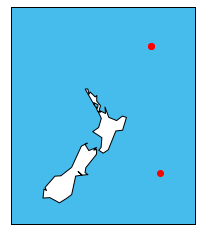

In [4]:
''' Plot the out of bounds stations '''

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

try:
    print('Stations excluded from the valid active station inventory')
    print(f'{invalid_st_list}')
    # determine range to print based on min, max lat and lon of the data
    st_lat = [x[1] for x in invalid_st_list]
    st_lon = [x[2] for x in invalid_st_list]

    lat_min = min(st_lat) - 5
    lat_max = max(st_lat) + 5
    lon_min = min(st_lon) - 20
    lon_max = max(st_lon) + 5

    # create map using BASEMAP
    m = Basemap(llcrnrlon=lon_min,
                llcrnrlat=lat_min,
                urcrnrlon=lon_max,
                urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2,
                lon_0=(lon_max-lon_min)/2,
                projection='merc',
                resolution = 'c',
                area_thresh=10000.,
                )
    
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    m.drawmapboundary(fill_color='#46bcec')
    m.fillcontinents(color = 'white',lake_color='#46bcec')
    # convert lat and lon to map projection coordinates
    lons, lats = m(st_lon, st_lat)
    # plot points as red dots
#    plt.figure(figsize=(5, 5))
    m.scatter(lons, lats, marker = 'o', color='r', zorder=5)
    plt.show()

except Exception as err:
    print("Error message:", err)

## Plot stations by sensor type
we plot all the valid land stations and color code them by type. The legend gives a description of the types, their capabilities, and quantities. The sensor types are distinguished between strong motion, weak motion, short-period, broadband, velocity measure, and acceleration measure. "[Not all ground motion sensors are created equal.](https://earthquake.alaska.edu/not-all-ground-motion-sensors-are-created-equal)" because not all ground motions are the same.

___TODO___ add google earth enging: 
* https://github.com/shiweihappy/earthengine-py-notebooks
* https://medium.com/@giswqs/300-jupyter-python-notebooks-for-using-google-earth-engine-with-interactive-mapping-bc3443119377 

### Observations about the sensor placement
Geonet has 5 types of sensors placed in various toplogical configurations. The plot shows that
* The shield network is, primarly, dominated by 59% strong mostion high broadband sensors measuring acceleration at high sampling rate 100-200Hz and, secondly, by 36% weak motion sensors measuring velocity at an extremely short-period sampling rate ~100Hz.
* A large propotion of weak motion sensors and the four broadband sensors, measuring acceleration at a very low sampling rate (1Hz), are placed in the northern island.
* The weak motion sensors, measuring velocity at a low sampling rate (1Hz). are uniformly scattered across both the northern and southern islands, except for the conscentration of sensors around the location -39.5, 175.5.
* Also the weak motion sensors measuring velocity high broadband sampled at 100-200Hz, are uniformaly scatter but concentrated in mostly to the north of latitude -44.0. There are two denser concentration of sensors around locations -38.5, 175.5 and -39.6, 176.5

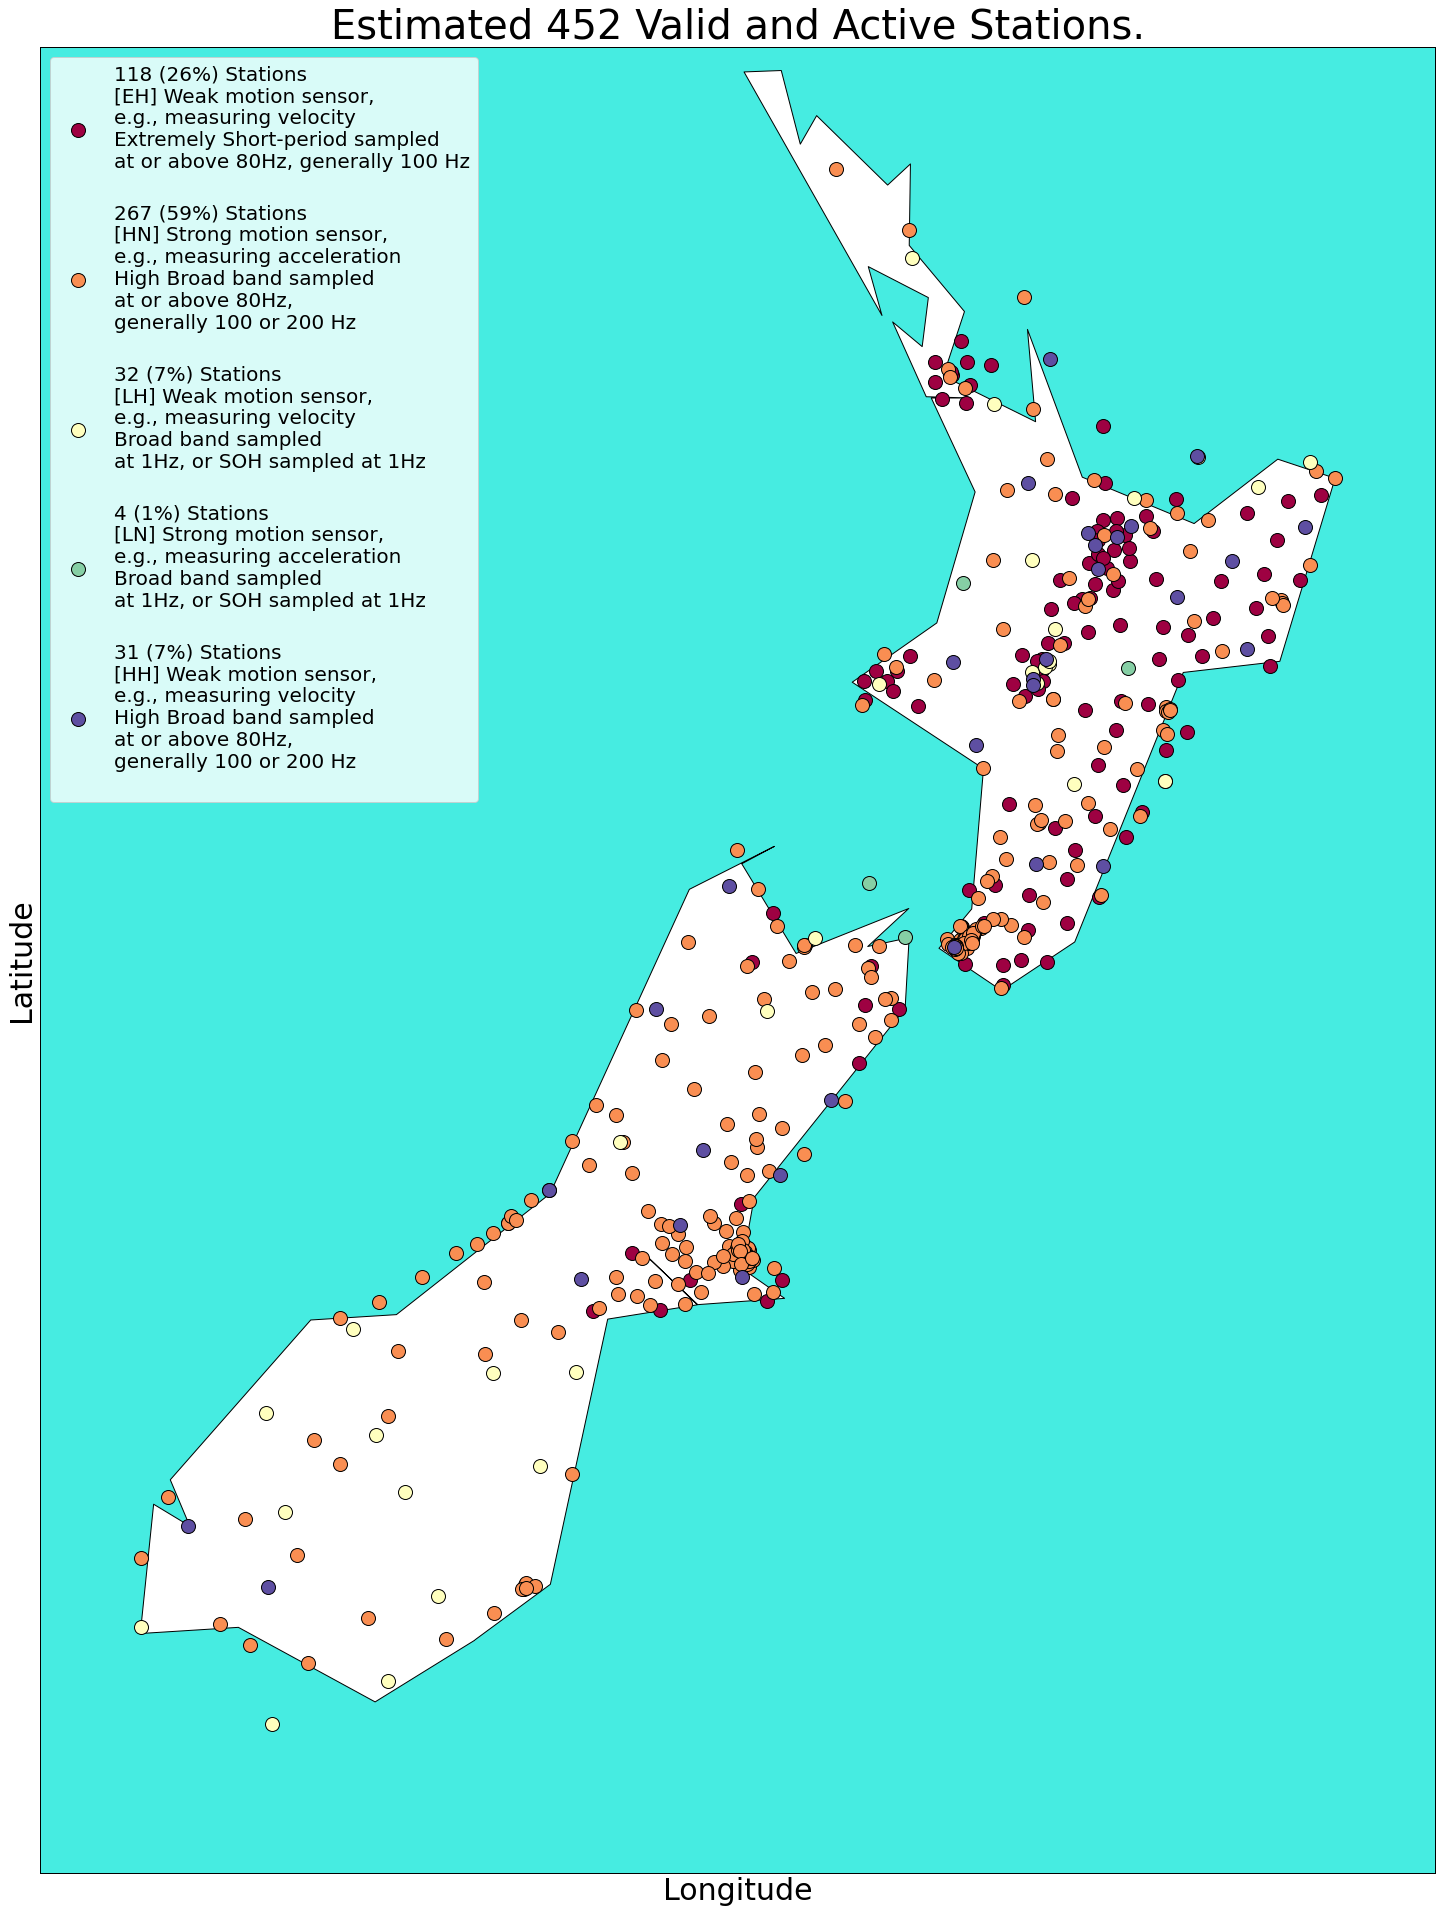

In [5]:
'''
    Topological plot of the staions by type
'''
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib.lines import Line2D
from mpl_toolkits.basemap import Basemap

lstStationType = []
lstStationLoc = []

''' prepare the list data of station types and coorinate '''
for _,st_type,st_lat,st_lon in st_list:
    lstStationType.append(st_type)
    lstStationLoc.append([st_lat,st_lon])
arrStationLoc = np.array(lstStationLoc)
st_type_dict = cls_st.get_types()

core_samples_mask = np.zeros_like(lstStationType, dtype=bool)
core_samples_mask[0:sum([len(x) for x in lstStationType])] = True

''' assign the color codes to the unique station types '''
unique_st_types = set(lstStationType)
colors = [plt.cm.Spectral(each) 
          for each in np.linspace(0, 1, len(unique_st_types))]

st_lat = [x[0] for x in lstStationLoc]
st_lon = [x[1] for x in lstStationLoc]

lat_min = min(st_lat) - 1
lat_max = max(st_lat) + 1
lon_min = min(st_lon) - 1
lon_max = max(st_lon) + 1

# create map using BASEMAP
plt.figure(figsize=(25, 40))
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(lon_max-lon_min)/2,
            projection='merc',
            resolution = 'c',
            area_thresh=10000.,
           )
    
m.drawcoastlines()
m.drawcountries()
#m.drawstates()
m.drawmapboundary(fill_color='#46ece1')
m.fillcontinents(color = 'white',lake_color='#46bcec')

''' Begin plotting the color coded stations '''
#plt.figure(figsize=(30, 40))
for k, col in zip(unique_st_types, colors):
    class_member_mask = (np.array(lstStationType) == k)
    xy = arrStationLoc[class_member_mask & core_samples_mask]
    s_legend = str(len(xy))+' ('+str(round(100*len(xy)/len(st_list)))+'%) Stations\n['+k+'] '+str(st_type_dict[k]+'\n')
    x,y = m(xy[:, 1], xy[:, 0])
    m.plot(x, y, 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14, label=s_legend)
#    m.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
#             markeredgecolor='k', markersize=14, label=s_legend)
    
plt.title('Estimated %d Valid and Active Stations.' % len(arrStationLoc), fontsize=40)
plt.xlabel('Longitude', fontsize=30)
plt.ylabel('Latitude', fontsize=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(loc='upper left', fontsize=20)
plt.show()

### Cluster Stations
One of the spatial clustering categories from GIS theory and technology tools, for objects with spatial geographical coordinates, a [cluster is an object of the spatial proximity base](https://ieeexplore.ieee.org/document/7529539) rather than as a clustering property similarity. The objective is to find clusters of stations that are with a given proximity to each other. The intent is to decide whether these stations, if they were able to communicate with each other, would conform to the properties of EEW rings. 

There are [several clustering methods](https://medium.com/locale-ai/geospatial-clustering-types-and-use-cases-6caedecfc7f0) that can be employed for grouping data with similar features. For the purpose of our exercise of clustering spatial data, partition clustering: [k-means](https://www.analyticsvidhya.com/blog/2021/02/simple-explanation-to-understand-k-means-clustering/), [k-medoids](https://www.geeksforgeeks.org/ml-k-medoids-clustering-with-example/), or [CLARA](https://medium.com/analytics-vidhya/partitional-clustering-using-clarans-method-with-python-example-545dd84e58b4) (Classification Large Application) [are unsuitable](https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/). Moreover, we would prefer a clustering algorithm that produce as many clusters based on the proximity criteria rather than grouping points that generate a desired "k" count of clusters. 

We are not interested in hierarchical clustering, such as [Agglomerative](https://medium.com/@MaheshGadakari/hierarchical-agglomerative-clustering-hac-with-single-linkage-method-1159fa623d52) or [Divisive](https://arxiv.org/pdf/1506.08977.pdf) hierarchical clustering that are also designed to generate a specified number of clusters. [DENCLUE](https://link.springer.com/chapter/10.1007/978-3-540-74825-0_7) is good for large dimensional data sets. It employs a hill climbing technique to estaimte the local optima. Since we are working only with geospatial data with latitude and longitude coordinates, we don't need to use denclue. If anyone wishes to implement, there's a [buggy version of denclue2](https://github.com/mgarrett57/DENCLUE) that can be repurposed.

There are also issues with clustering geospatial data. [Around the equator the results should be fairly accurate.](https://stackoverflow.com/questions/24762435/clustering-geo-location-coordinates-lat-long-pairs-using-kmeans-algorithm-with) but close to one of the poles the results won't be useful at all. It might, however, work as a pre-pocessing step or for applications with low precision requirements, e.g. small, non-overlapping and very distinct clusters.

In [4]:
''' Only apply to strong and weak motion stations with sampling rates > 80Hz
    Convert the data as an Numpy array before clustering
    
    lst_st_type_80Hz_above: list of stations types with sampling rate > 80Hz
    lst_st_coord_80H_above: new station list of type in lst_st_type_80Hz_above
    station_coordinates: are the preprocessed array ready for clustering
'''

import numpy as np

lst_st_type_80Hz_above = ['HN', 'HH', 'EH']
lst_st_coord_80H_above = [[st_lat,st_lon] 
                          for _,st_type,st_lat,st_lon in st_list 
                          if st_type in lst_st_type_80Hz_above]

''' Convert to float to avoid throwing a datatype error in the plot function '''
#station_coordinates = np.array(lstStationLoc).astype(np.float)
station_coordinates = np.array(lst_st_coord_80H_above).astype(np.float)
print('%d stations of type %s are ready for clustering' % (len(station_coordinates),lst_st_type_80Hz_above))

416 stations of type ['HN', 'HH', 'EH'] are ready for clustering


### Spatial Clustering Methods

#### DBSCAN
_Density-Based Spatial Clustering of Applications with Noise_ ([DBSCAN](https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/)) is the most appropriate clustering method because, as in this case, it is mostly used for ___clustering in planar space___ and is good for handling outliers. Unlike k-means clustering that considers the variance, DBSCAN considers a distance function. The objective is to cluster stations with a maximum distance between each other. Inherent ___problem of DBSCAN___ is that it characterises data points to be in the same clusted if pair-wise data points satisfy the epsilon condition. This would not adequately satisfy the required condition that all data points in a a cluster are within the desired epsilon distance. It uses the concept of density reachability and density connectivity.

#### HDBSCAN

_Density-Based Clustering Based on Hierarchical Density Estimates_ ([HDBSCAN](https://link.springer.com/chapter/10.1007%2F978-3-642-37456-2_14)) was developed by Campello, Moulavi, and Sander (2013) - a simplified tree of significant clusters are constructed for obtaining a “flat” partition consisting of only the most significant clusters (possibly corresponding to different density thresholds). [How HDBSCAN works](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) is "it extends DBSCAN by converting it into a hierarchical clustering algorithm, and then using a technique to extract a flat clustering based in the stability of clusters."

#### OPTICS

_Ordering points to identify the clustering structure_ [OPTICS](https://towardsdatascience.com/clustering-using-optics-cac1d10ed7a7) addresses the [limitations of input parameter selection for DBSCAN](https://www.mdpi.com/2079-9292/8/10/1094). However, OPTICS requires distance computations for all pairs of objects to create a reachability plot. Another interesting aspect of the OPTICS algorithm is an extension of it used for outlier detection, called OPTICS-OF (OF for Outlier Factor). This will give an outlier score to each point, that is a comparison to its closest neighbors rather than the entire set. One downfall of OPTICS-OF detection is that is cannot handle duplicates well. If enough points occupy the same space, they can have a reach-ability distance of 0, which causes problems in our local outlier factor calculations. 

#### TODO

#### Grid-based clustering
[Grid-based clustering](https://www.researchgate.net/publication/50315642_A_Survey_of_Grid_Based_Clustering_Algorithms_) would also work. Of particular interest is the [STING](https://www.geeksforgeeks.org/difference-between-sting-and-optics/), [Wave cluster](), and [ASGC]() grid-based spatial clustering algorithms.

[Affinity Propagation](https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html) is a graph based exemplar voting method where the user doesn’t need to specify the number of clusters. Since it partitions the data just like K-Means we expect to see the same sorts of problems, particularly with noisy data. [Mean Shift](https://www.geeksforgeeks.org/ml-mean-shift-clustering/) is another option if you don’t want to have to specify the number of clusters. It is centroid based, like K-Means and affinity propagation, but can return clusters instead of a partition. Spectral clustering can best be thought of as a graph clustering. For spatial data one can think of inducing a graph based on the distances between points (potentially a k-NN graph, or even a dense graph).

We may also consider State Vector Machine (SVM) to further separate the clusters and [reduce the noise](https://www.researchgate.net/publication/325116579_Scalable_density_based_spatial_clustering_with_integrated_one-class_SVM_for_noise_reduction).

In [6]:
import sys
sys.path.insert(1, '../lib')
import clustering
from sklearn import metrics

''' 
    Options are: DBSCAN, HDBSCAN, OPTICS, KMEANS, DENCLUE 
    for KMEANS clustering method, be sure to enable max_iter & random_state parameters below
    if you don't wish to use them, disable the max_iter & random_state for other clustering methods
'''
s_clust_name = 'DBSCAN'

''' DBSCAN, HDBSCAN, OPTICS, KMEANS,MEANSHIFT paramter dictionary

    @parameters
    algorithm = {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’
    metric = {'haversine','euclidean'}   % any of listed in scipy.spatial.distance
    cluster_method = {'xi', 'dbscan'}   % use when running OPTICS
'''
dict_clust_params = {"distance_km":30.0, 
                     "minimum_samples": 4, 
                     "algorithm": 'auto',
                     "metric": 'haversine',
                     "cluster_method": 'xi',
                     "fit_predict": True}
''' 
    When running KMEANS, append the KMEANS paramter below to the parameter dictionary
    
    @parameters
    max_iter=300 (Maximum number of iterations for a single run)
    random_state=5 (Determines random number generation for centroid initialization)
'''
#dict_clust_params["max_iter"]=300
#dict_clust_params["random_state"]=5
try:
    cls_clust = clustering.cluster_data(s_clust_name,**dict_clust_params)
    labels, labels_true, clust_centers = cls_clust.get_clusters(station_coordinates)

    ''' Number of clusters in labels, ignoring noise if present. '''
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('')
    print('Total number of stations: %d' % len(labels))
    print('Estimated number of clusters: %d' % n_clusters_)    
    print('Estimated number of noise points: %d' % n_noise_)
    
    if n_clusters_ == 1:
        raise ValueError('Clusters size is %d. Cannot estimate cluster quality indicators' % n_clusters_)
    else:
        print("Silhouette Coefficient: %0.3f" 
              % metrics.silhouette_score(station_coordinates, labels))
        print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
        print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
        print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
        print("Adjusted Rand Index: %0.3f"
              % metrics.adjusted_rand_score(labels_true, labels))
        print(f"Adjusted Mutual Information: %0.3f" 
              % metrics.adjusted_mutual_info_score(labels_true, labels))

except Exception as err:
    print("Error message:", err)

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


DBSCAN(eps=0.004708830413167849, metric='haversine', min_samples=4)

Total number of stations: 416
Estimated number of clusters: 11
Estimated number of noise points: 69
Silhouette Coefficient: 0.141
Homogeneity: 0.317
Completeness: 1.000
V-measure: 0.481
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000


#### Separate array for no-noise & noise plots 

In [7]:
''' create two separate station arrays removing the noise and purely noise clusters '''
try:
    if station_coordinates.shape[0] != labels.shape[0]:
        raise ValueError('Mismatch in station coordinate and labels array sizes to; cannot proceed')

    tmp_arr = np.insert(station_coordinates,2,labels, axis=1)
    no_noise_st_arr = np.array([x for i,x in enumerate(tmp_arr) if np.any(tmp_arr[i][2] >= 0)])
    noise_st_arr = np.array([x for i,x in enumerate(tmp_arr) if np.any(tmp_arr[i][2] < 0)])

except Exception as err:
    print("Error message:", err)

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Plot results
1. [Plot DBSCAN results](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py) clusters with varied colors unique to each cluster
1. plot fault lines to show closes sensor in cluster to the fault line

Calculate and plot [cluster center most point](https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/).

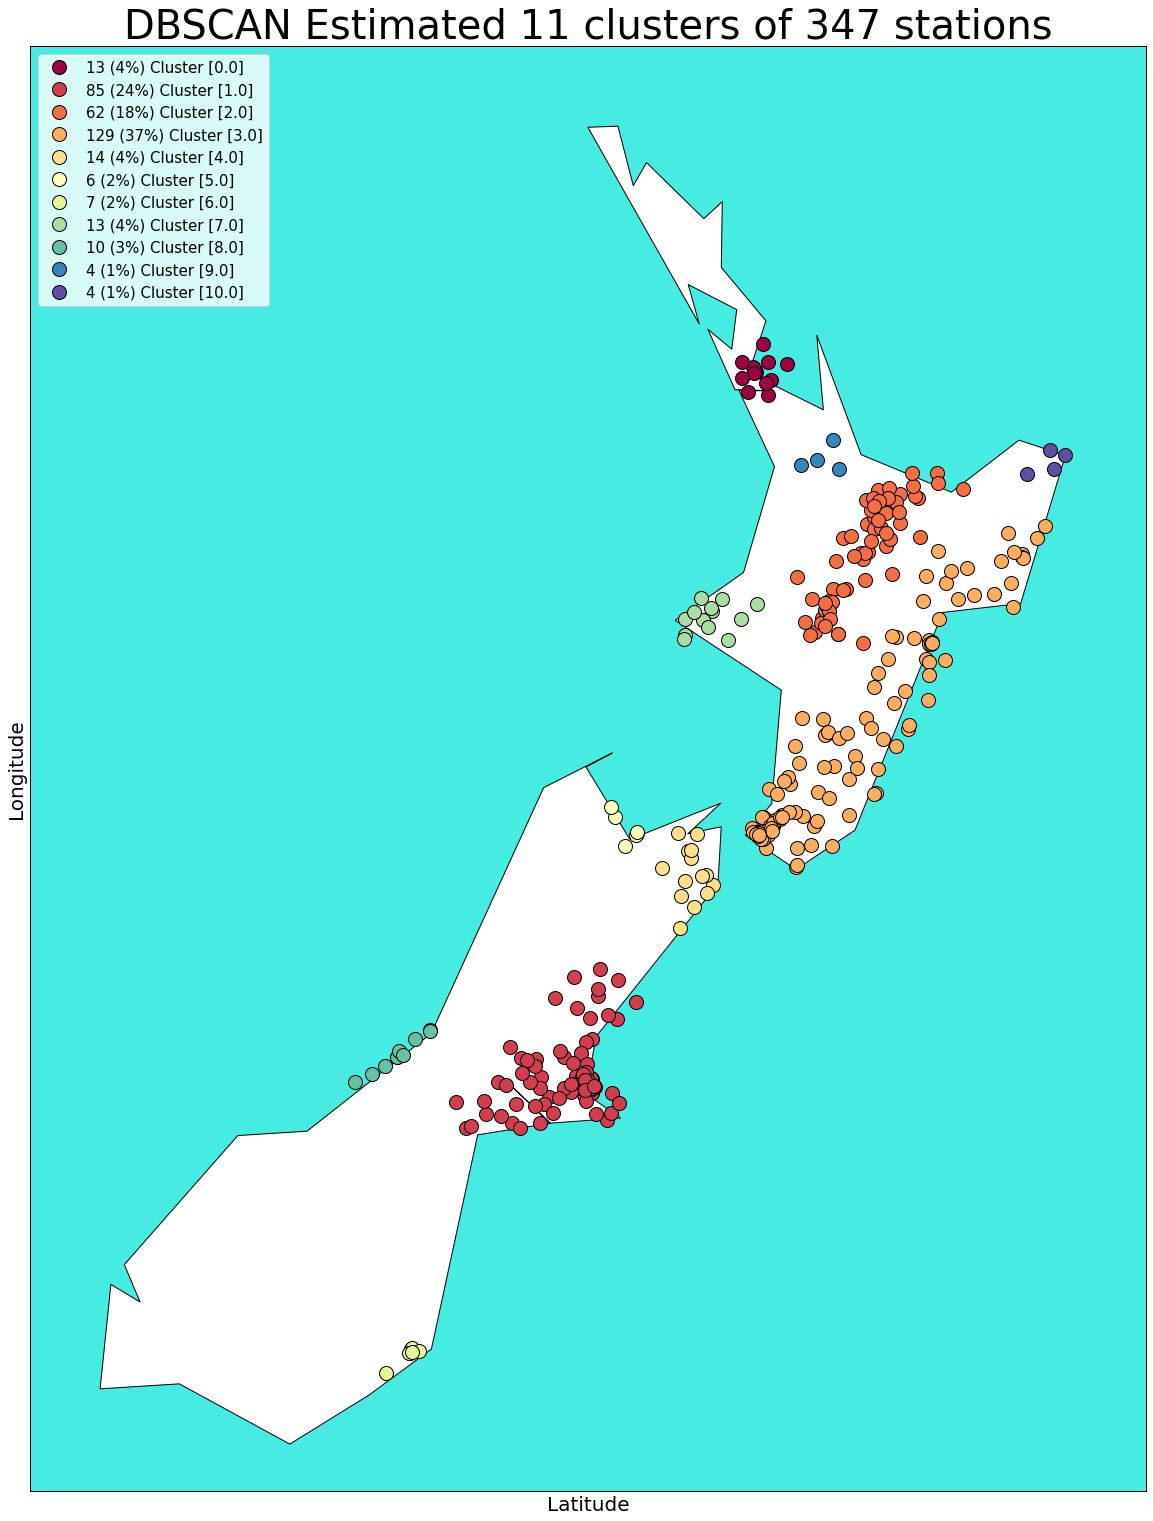

In [8]:
''' Plot clusters on a map '''
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

try:
    ''' check if cluster size is same as all points '''
    if no_noise_st_arr.shape[0] == station_coordinates.shape[0]:
        raise ValueError('There is only one cluster; does not make sense to plot')

    # create map using BASEMAP
    st_lat = no_noise_st_arr[:,0]
    st_lon = no_noise_st_arr[:,1]

    lat_min = min(st_lat) - 1
    lat_max = max(st_lat) + 3
    lon_min = min(st_lon) - 4
    lon_max = max(st_lon) + 1

    plt.figure(figsize=(20, 35))
    m = Basemap(llcrnrlon=lon_min,
                llcrnrlat=lat_min,
                urcrnrlon=lon_max,
                urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2,
                lon_0=(lon_max-lon_min)/2,
                projection='merc',
                resolution = 'c',
                area_thresh=10000.,
               )

    m.drawcoastlines()
    m.drawcountries()
    #m.drawstates()
    m.drawmapboundary(fill_color='#46ece1')
    m.fillcontinents(color = 'white',lake_color='#46bcec')

    unique_labels = set(no_noise_st_arr[:,2])
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]

    #plt.figure(figsize=(15,20))
    for k, col in zip(unique_labels, colors):
        xy = np.array([x for i,x in enumerate(no_noise_st_arr) if np.any(no_noise_st_arr[i][2] == k)])
        s_legend = str(len(xy))+' ('+str(round(100*len(xy)/len(no_noise_st_arr)))+'%) Cluster ['+str(k)+']'
        x,y = m(xy[:, 1], xy[:, 0])
        m.plot(x, y, 'o', markerfacecolor=tuple(col),
               markeredgecolor='k', markersize=14, label=s_legend)

    plt.title('%s Estimated %d clusters of %d stations' 
              % (s_clust_name, n_clusters_, no_noise_st_arr.shape[0]), fontsize=40)
    plt.xticks(size=10)
    plt.yticks(size=10)
    plt.legend(loc='upper left', fontsize=15)
    plt.xlabel('Latitude', fontsize=20)
    plt.ylabel('Longitude', fontsize=20)
    plt.show()

except Exception as err:
    print("Error message:", err)

#### Plot Noise
Plot of stations that do not belong to any cluster because they don't fit the epsilon criterion.

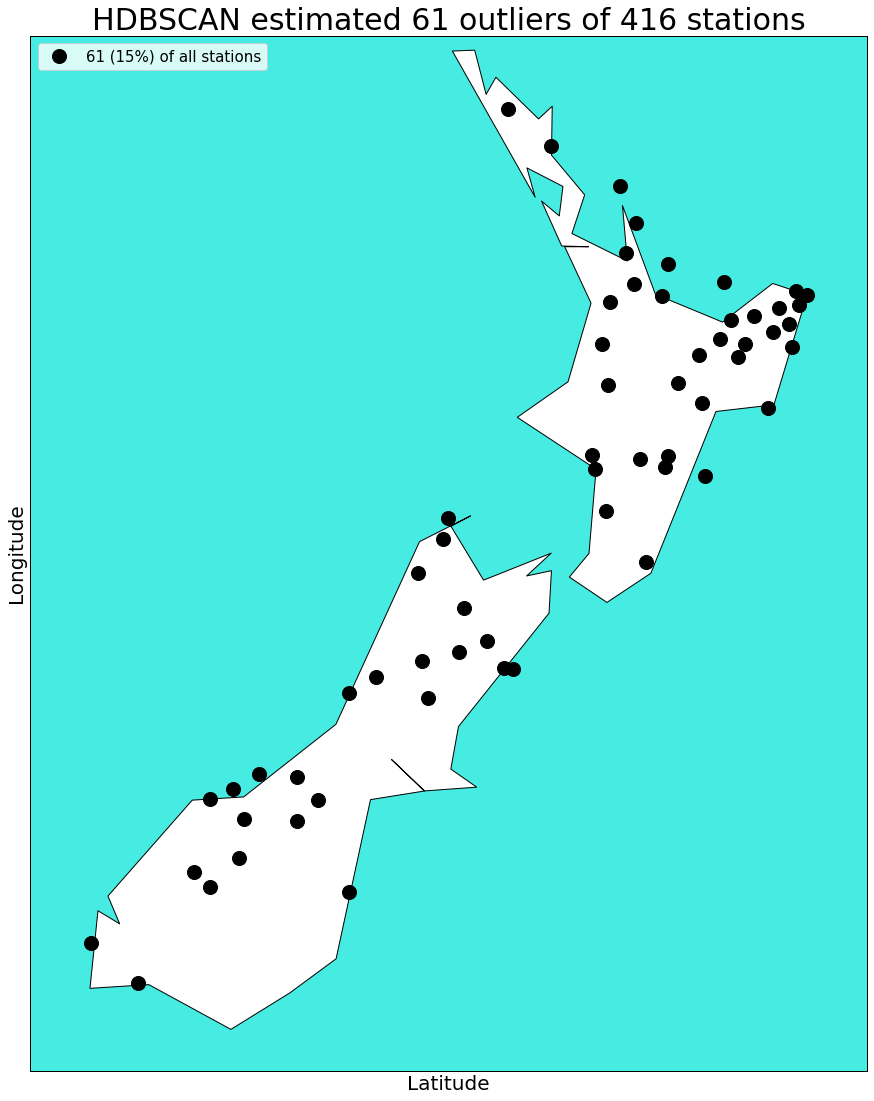

In [25]:
''' Plot noise cluster points on a map '''
#noise_st_arr = np.array([x for i,x in enumerate(tmp_arr) if np.any(tmp_arr[i][2] < 0)])

try:
    if not noise_st_arr.all():
        raise ValueError('There are no noise clusters to plot')

    # create map using BASEMAP
    st_lat = noise_st_arr[:,0]
    st_lon = noise_st_arr[:,1]

    lat_min = min(st_lat) - 1
    lat_max = max(st_lat) + 1
    lon_min = min(st_lon) - 1
    lon_max = max(st_lon) + 1

    plt.figure(figsize=(15, 20))
    m = Basemap(llcrnrlon=lon_min,
                llcrnrlat=lat_min,
                urcrnrlon=lon_max,
                urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2,
                lon_0=(lon_max-lon_min)/2,
                projection='merc',
                resolution = 'c',
                area_thresh=10000.,
               )
    
    m.drawcoastlines()
    m.drawcountries()
    #m.drawstates()
    m.drawmapboundary(fill_color='#46ece1')
    m.fillcontinents(color = 'white',lake_color='#46bcec')

    col = [0, 0, 0, 1]   # black
    s_legend = str(len(noise_st_arr))+' ('+str(round(100*len(noise_st_arr)/len(tmp_arr)))+'%) of all stations'
    x,y = m(noise_st_arr[:, 1], noise_st_arr[:, 0])
    m.plot(x, y, 'o', markerfacecolor=tuple(col),
           markeredgecolor='k', markersize=14, label=s_legend)

    plt.title('%s estimated %d outliers of %d stations' 
              % (s_clust_name, noise_st_arr.shape[0], tmp_arr.shape[0]), fontsize=30)
    plt.xticks(size=10)
    plt.yticks(size=10)
    plt.legend(loc='upper left', fontsize=15)
    plt.xlabel('Latitude', fontsize=20)
    plt.ylabel('Longitude', fontsize=20)
    plt.show()

except Exception as err:
    print("Error message:", err) 

### Density Reachability and Connectivity

We intend to calculate the [density reachability](https://www.geeksforgeeks.org/ml-dbscan-reachability-and-connectivity/). __Why?__ Let ε be the radius of a neighborhood with respect to some point. The _core objects_ the minimum number of objects in that ε-neighborhood. An object (or instance) _q_ is directly density reachable from object _p_ if _q_ is within the ε-Neighborhood of _p_ and _p_ is a core object. ___Density connectivity___ implies that Object _q_ is density-connected to object _p_ w.r.t ε and mimumum points if there is an object _o_ such that both _p_ and _q_ are density-reachable from object _o_ w.r.t _ε_ and the minimum points.

___Do now___
1. Build a complete graph from the cluster core objects
1. Use the nearest neigbour distance as the edge weigt
1. create a minimal spanning tree to connect all core objects

___future work___
1. also create a reachability metric from the clusters to the outliers
1. use that to determine a strategy for placing new nodes to improve the density connectivity and reachability


### Mean Nearest Neighbour Distance Statistics

Compute the mean distance between nearest neigbours of a minimum 3 points
* https://scikit-learn.org/stable/modules/neighbors.html
* https://pysal.org/notebooks/explore/pointpats/distance_statistics.html#Mean-Nearest-Neighbor-Distance-Statistics
* https://knaidoo29.github.io/mistreedoc/minimum_spanning_tree.html

In [131]:
import numpy as np
from matplotlib.pyplot import figure
import networkx as nx
#from networkx.algorithms import tree
from sklearn.metrics.pairwise import haversine_distances

unique_labels = set(no_noise_st_arr[:,2])
lst_clust_G = []

print('Creating a minimal spanning trees for each of the %d clusters' % (len(unique_labels)))
for clust_lbl in unique_labels:
    G = nx.Graph()
    H = nx.Graph()
    clust_st = np.array([x for x in no_noise_st_arr if x[2] ==clust_lbl])
    dist_arr = haversine_distances(np.radians(clust_st[:,:2]),np.radians(clust_st[:,:2]))

    for i in range(dist_arr.shape[0]):
        G.add_node(i,pos=(clust_st[i,1],clust_st[i,0]),label=clust_st[i,2])
        for j in range(i,dist_arr.shape[1]):
            if j>i:
                H.add_edge(i,j,distance=round(dist_arr[i,j]*6371.088,2))

    ''' @parameters
        algorithm = {‘kruskal’, ‘prim’, or ‘boruvka’}
    '''
    T = nx.minimum_spanning_edges(H, weight='distance', algorithm='boruvka', data=True)
    edgelist = list(T)
    G.add_edges_from(edgelist)
    lst_clust_G.append(G)
print('Complete')

Creating a minimal spanning trees for each of the 11 clusters
Complete


#### Make individual polts of network graphs
Change the ```cluster_num``` to any number between 0 and the maximum number of cluster -1

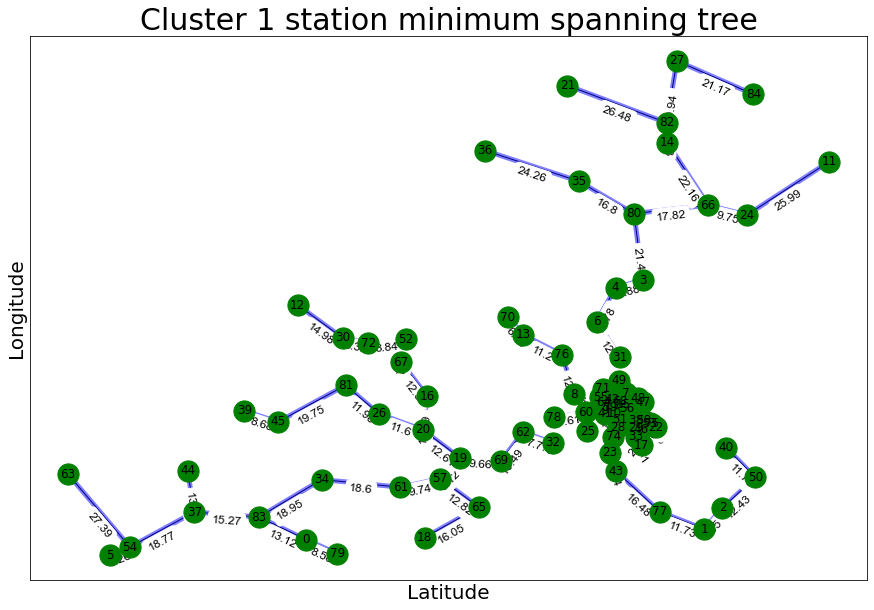

In [127]:
''' 
    Plot the minimal spanning tree
    
    To plot the minimal spanning tree graph for any of the clusters change the clust_num
    to view the plot for that specfic cluster
    
    @parameters
    clust_number = integer value of any number between 0 and the maximum number of cluster -1
    G = nx.Graph() instance of the respecitve graph of the cluster from the list of cluster graphs
'''
clust_num = 1
figure(figsize=(15,10))
G = lst_clust_G[clust_num]
node_pos=nx.get_node_attributes(G,'pos')
nx.draw_networkx(G, node_pos,node_size=450, node_color="g")
nx.draw_networkx_edges(G, node_pos, width=5.0, alpha=0.5,edge_color="b")
edge_labels = nx.get_edge_attributes(G,'distance')
nx.draw_networkx_edge_labels(G, node_pos,
                             edge_labels=edge_labels, label_pos=0.5,
                             font_size=12, font_family="Arial",
                             horizontalalignment='center', verticalalignment='top')
plt.title('Cluster %d station minimum spanning tree' % (clust_num), fontsize=30)
plt.xticks(size=10)
plt.yticks(size=10)
#plt.legend(loc='upper left', fontsize=15)
plt.xlabel('Latitude', fontsize=20)
plt.ylabel('Longitude', fontsize=20)
plt.show()


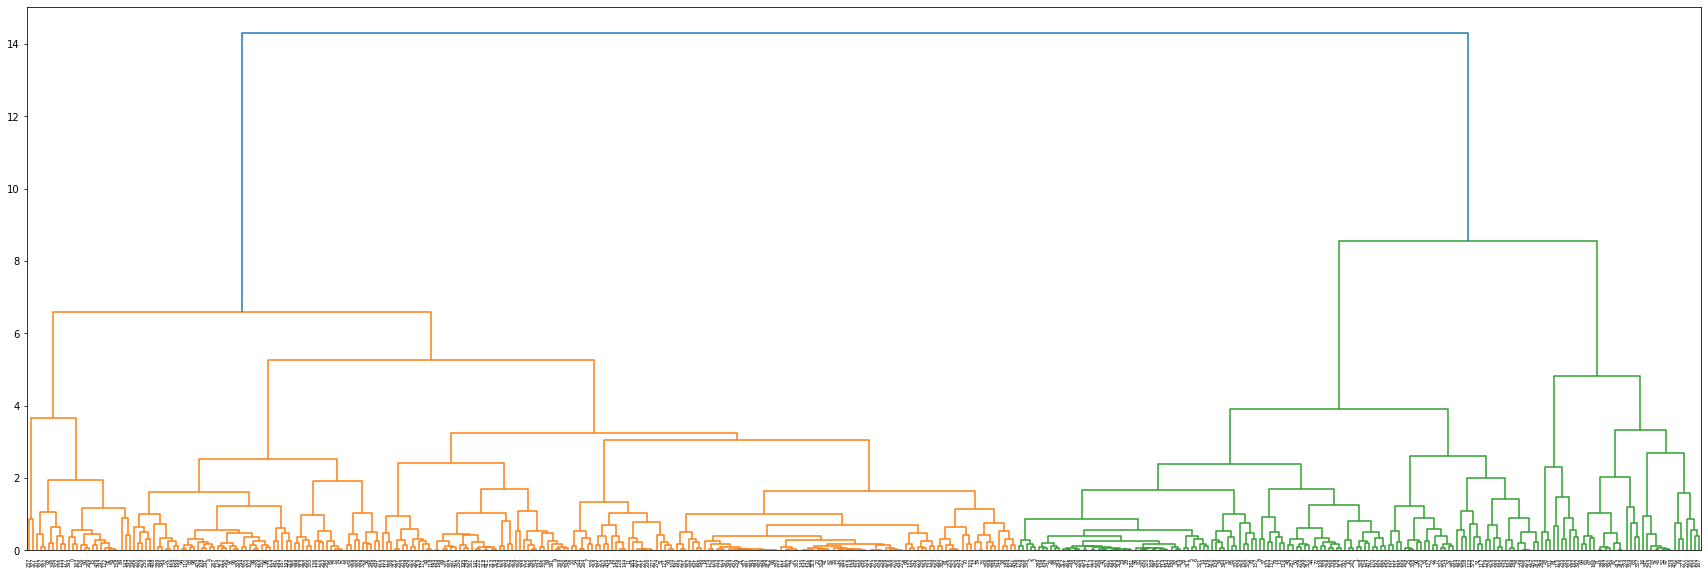

In [111]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# generate the linkage matrix
#X = locations_in_RI[['Latitude', 'Longitude']].values
Z = linkage(station_coordinates,
            method='complete',  # dissimilarity metric: max distance across all pairs of 
                                # records between two clusters
            metric='euclidean'
    )                           # you can peek into the Z matrix to see how clusters are 
                                # merged at each iteration of the algorithm

# calculate full dendrogram and visualize it
plt.figure(figsize=(30, 10))
dendrogram(Z)
plt.show()

# retrive clusters with `max_d`
from scipy.cluster.hierarchy import fcluster
max_d = 30       # I assume that your `Latitude` and `Longitude` columns are both in 
                 # units of miles
clusters = fcluster(Z, max_d, criterion='distance')

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

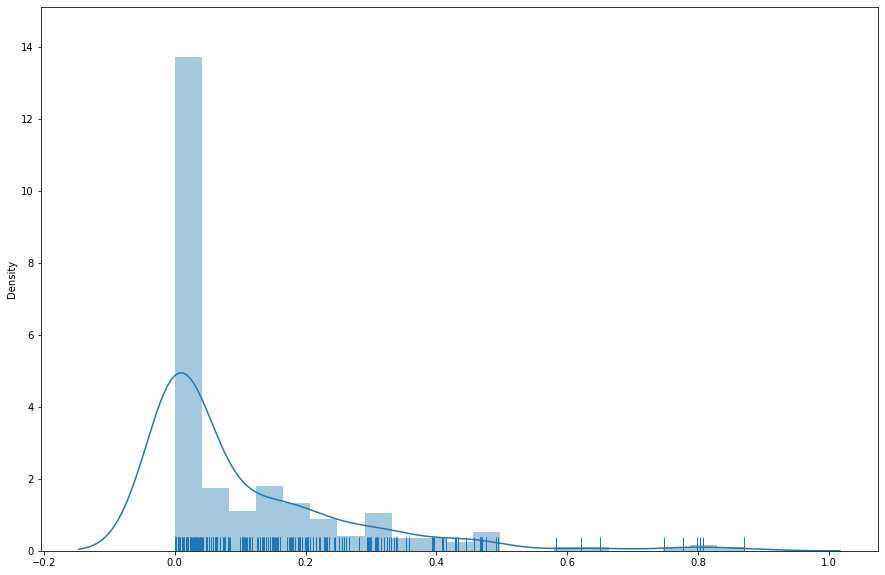

In [21]:
import seaborn as sns
from matplotlib.pyplot import figure

figure(figsize=(15,10))
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)

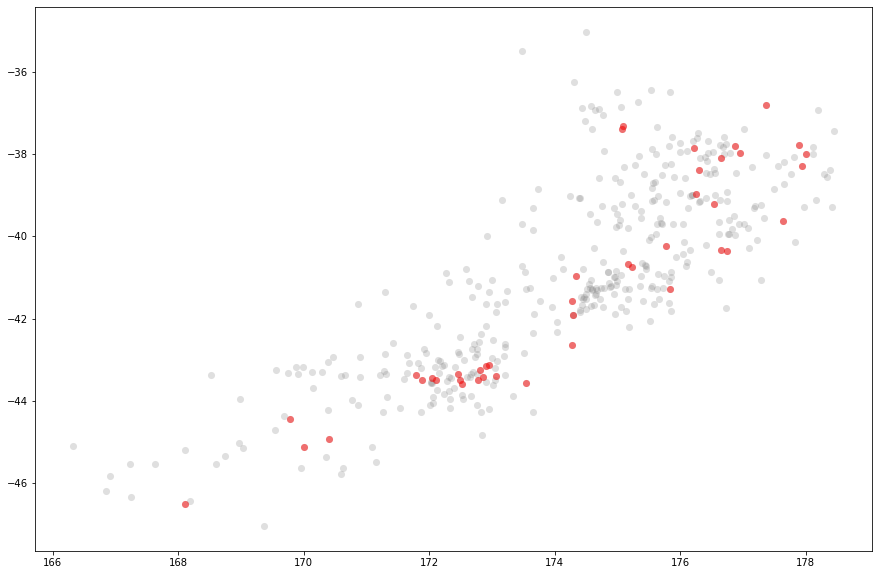

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
plt.scatter(*X.T, s=50, linewidth=0, c='gray', alpha=0.25)
plt.scatter(*X[outliers].T, s=50, linewidth=0, c='red', alpha=0.5)

In [132]:
pal = sns.color_palette('deep', 8)
colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clusterer.labels_,
                                                            clusterer.probabilities_)]
plt.scatter(station_coordinates.T[0], station_coordinates.T[1], c=colors, **plot_kwds);

NameError: name 'sns' is not defined

In [2]:
from matplotlib.pyplot import figure

figure(figsize=(15,10))
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

NameError: name 'clusterer' is not defined

<Figure size 1080x720 with 0 Axes>

### Parametric analysis of the clusters

A large propotion of the sensors could be clustered to have, at least, 03 senors in a cluster and that they are < 30Km distance from each other; which also is the basis for the ```eps = 30.0/6371.0088``` (epsilon convereted to radians using the length of Earth's radius 6371Km). The estimated number of _noise points_ tell us the number of sensors that didn't belong to any cluster. The particular geodedic data cannot be clustered with KD-Trees or any Tree algorithm. However, chosing ```algorithm = "ball_tree"``` is recommended as it is well suited for geospatial data clustering. The ```metric = "haversine"``` is naturally required to calculate the distance between two geographical points. Finally, the ```st_dbscan_arr``` comprising latitude and longitude decimal data is converted to radians to be consistent with using the _haversine_ distance funcation.

### Voronoi diagram of the Station Clusters
A [Voronoi diagram is a collection of polygons](https://towardsdatascience.com/how-to-create-voronoi-regions-with-geospatial-data-in-python-adbb6c5f2134) with all the points on a plane that is closest to the single object - each polygon division correlates with a single object and contains all points which are closest to this single object.

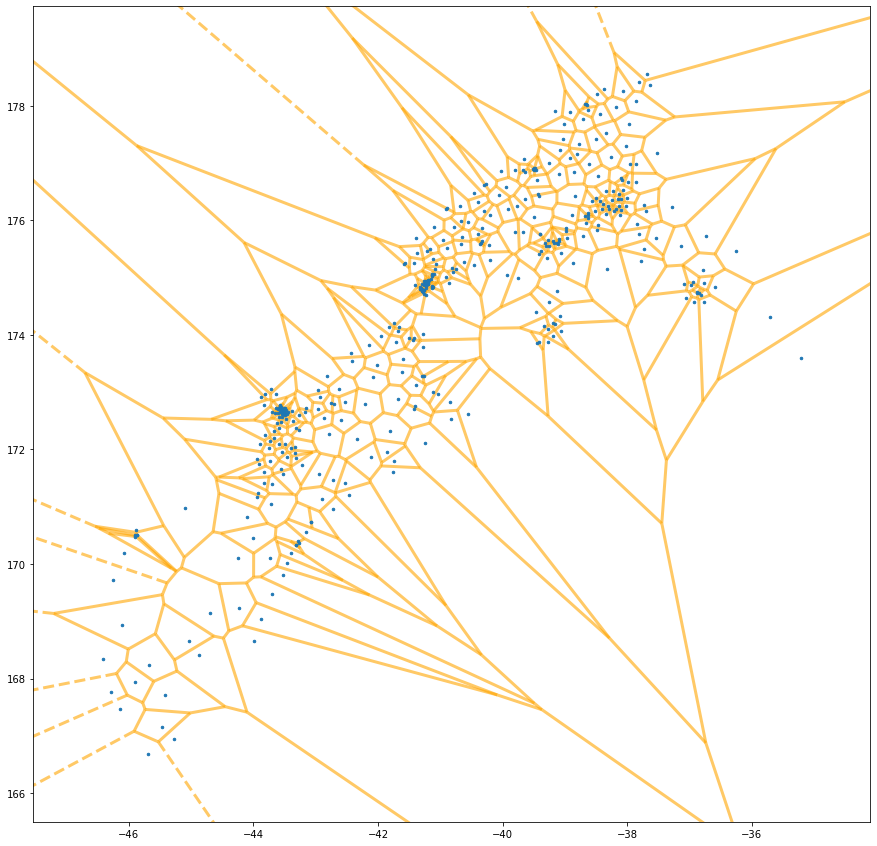

In [6]:
'''
    PLOT Voroni diagram of the stations
    TODO put inside geographic boundary
'''
from scipy.spatial import Voronoi, voronoi_plot_2d
#arr_clust_coords = np.array([[row[0],row[6]] for row in l_st_flt_clust])
#print([labels[:],scaled_features[:, 0], scaled_features[:, 1]])
#arr_coord = np.array(list([row[2][0],row[2][1]] for row in station_coordinates))
vor = Voronoi(station_coordinates)
#fig = voronoi_plot_2d(vor)
fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='orange', 
                      line_width=3, line_alpha=0.6, point_size=5)
fig.set_size_inches(15,15)
#plt.axis("equal")
#plt.xlim

In [27]:
''' NOT WORKING maybe redundant '''
from sklearn.neighbors import NearestNeighbors

# Augment station array with cluster number
# Start a new station coorinates and details tuple
st_list = []
i=0
for i in range(len(labels)):
    st_row = [tmp_arr[i,0],labels[i],tmp_arr[i,1],tmp_arr[i,2],tmp_arr[i,3]]
    st_list.append(list(st_row))

clusters = list({item[1] for item in st_list})

for each_cluster in clusters:
    cluster_list = list(st_list[j] for j in range(len(st_list)) if st_list[j][1] == each_cluster)
    cluster_arr = np.delete(cluster_list, [0,1,4],axis=1).astype(np.float)
    nbrs = NearestNeighbors(n_neighbors=3, algorithm='brute', metric='haversine').fit(cluster_arr)
    distances, indices = nbrs.kneighbors(cluster_arr)
    print(nbrs.kneighbors_graph(cluster_arr).toarray())
    
    each_cluster_clique = client.get_stations(latitude=-42.693,longitude=173.022,maxradius=30.0/6371.0, starttime = "2016-11-13 11:05:00.000",endtime = "2016-11-14 11:00:00.000")
    print(each_cluster_clique)
    _=inventory.plot(projection="local")
    
    break

sorted_rank = sorted(st_list, key=lambda i: (int(i[1])), reverse=True)
#print('Code, Cluster, Latitude, Longitude, Elevation')
#print(sorted_rank)

NameError: name 'tmp_arr' is not defined